<a href="https://colab.research.google.com/github/rvanasa/deep-antibody/blob/master/antibody_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Google Drive setup

from IPython.display import clear_output
from google.colab import drive
drive.mount('/gdrive')
clear_output()

In [ ]:
#@title Workspace setup

!pip install -q biopython pdb-tools

from IPython.display import clear_output, display
clear_output()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import Bio
import Bio.PDB
from Bio.PDB import DSSP

contact_buffer = 4
contact_window_size = contact_buffer * 2 + 1

amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', '???']
oneletters = 'ARNDCEQGHILKMFPSTWYV'
ssletters = 'HBEGITS'

parser = Bio.PDB.PDBParser(QUIET=True)

def parse(ident, cache_dir=None):
  cache_dir = cache_dir.rstrip('/') + '/' if cache_dir else ''
  filename = ident if ident.endswith('.pdb') else f'{cache_dir}{ident}.pdb'
  if '.' not in ident and not os.path.exists(filename):
    !wget -N https://files.rcsb.org/download/{ident}.pdb
    !mv {ident}.pdb {cache_dir}
  return parser.get_structure(ident, filename)

loaded_dssp = False

def run_dssp(filename, cache_dir=None):
  global loaded_dssp
  if not loaded_dssp:
    loaded_dssp = True
    !wget -nc ftp://ftp.cmbi.ru.nl/pub/software/dssp/dssp-2.0.4-linux-amd64 -O /usr/local/bin/dssp && chmod +x /usr/local/bin/dssp
  
  structure = parse(filename, cache_dir)
  adfs = []
  for model in structure.get_models():
    index_lookup = {(chain.id, res.id): i for chain in model.get_chains() for i, res in enumerate(trim_residues(chain.get_residues()))}

    dssp = DSSP(model, filename)
    rows = [(key, index_lookup[key, res_id], *v[1:]) for (key, res_id), v in dssp.property_dict.items()]

    dfs = pd.DataFrame(rows, columns=[
        'Key', 'Index', 'Residue',
        'SS', 'ASA', 'Phi', 'Psi',
        'NH->O_1_relidx', 'NH->O_1_energy',
        'O->NH_1_relidx', 'O->NH_1_energy',
        'NH->O_2_relidx', 'NH->O_2_energy',
        'O->NH_2_relidx', 'O->NH_2_energy'])
    
    dfs.insert(0, 'Model', model.id)
    adfs.append(dfs)
  return pd.concat(adfs)


def trim_residues(rs):
  rs = [r for r in rs if r.resname != 'HOH']
  while rs and rs[0].resname not in amino_acids:
    rs = rs[1:]
  while rs and rs[-1].resname not in amino_acids:
    rs = rs[:-1]
  return rs


def create_seq(rs):
  return ''.join(oneletters[amino_acids.index(r)] if r in amino_acids else 'X' for r in rs)


def cmd(command):
  if not isinstance(command, str):
    for c in command:
      cmd(c)
  elif os.system(command):
    raise Exception(f'Non-zero exit code in command: $ {command}')

In [ ]:
#@title Feature encoding

def encode_onehot(x, y, size=None):
  encoded = np.zeros((size or len(x), len(y)), dtype=np.bool)
  # for i, z in enumerate(y):
  #   indices = x.str.index(z)
  #   encoded[x == indices, i] = 1
  a = np.array([y.index(k) for k in x])
  encoded[np.arange(len(x)), a] = 1
  return encoded


def encode_onehot_all(xs, y):
  return np.array([encode_onehot(x, y) for x in xs]).reshape(len(xs), -1)


def encode_features(df, verbose=True):
  cdrs = encode_onehot(df.Type + df.CDR.astype(str), [f'{t}{c}' for t in 'HL' for c in '123'])
  # cdrs = (encode_onehot(df.Type, 'LH')[:, :, None] * encode_onehot(df.CDR, (1, 2, 3))[:, None, :]).reshape(len(df), -1)
  if verbose: print(cdrs.shape)

  bwindows = encode_onehot_all(df.BWindow, oneletters)
  awindows = encode_onehot_all(df.AWindow, oneletters)
  if verbose: print(bwindows.shape, awindows.shape)
  assert bwindows.shape == awindows.shape

  ss_onehot = ssletters + '-'
  
  bsecs = encode_onehot_all(df.BSec.str.split('|'), ss_onehot)
  asecs = encode_onehot_all(df.ASec.str.split('|'), ss_onehot)
  if verbose: print(bsecs.shape, asecs.shape)
  assert bsecs.shape == asecs.shape

  bsols = np.array(list(df.BSol.str.split('|').map(lambda a: [float(f) if f else 0 for f in a])))
  asols = np.array(list(df.ASol.str.split('|').map(lambda a: [float(f) if f else 0 for f in a])))
  if verbose: print(bsols.shape, asols.shape)
  assert bsols.shape == asols.shape
  
  positions = (df.BIndex - df.CDR_S) / (df.CDR_EI - df.CDR_S)

  return np.concatenate([
      cdrs.T,
      bwindows.T,
      bsecs.T,
      bsols.T,
      awindows.T,
      asecs.T,
      asols.T,
      [positions],
      [1 - positions],
  ]).astype(np.float32).T

def encode_labels(df):
  # return encode_onehot(df.Label, list(range(2)))
  # return np.hstack([df.Label, 1 - df.Label])
  return np.array(df.Label)

def generate_batch(df, multiple=2):
  # r_wkeys = ['BWindow', 'AWindow']
  # r_skeys = ['BSec', 'BSol', 'ASec', 'ASol']
  # df_reverse = df.copy()
  # df_reverse[r_wkeys] = df[r_wkeys].applymap(lambda w: w[::-1])
  # df_reverse[r_skeys] = df[r_skeys].applymap(lambda s: '|'.join(s.split('|')[::-1]))
  # df_reverse.BIndex = df_reverse.CDR_S + df_reverse.CDR_EI - df_reverse.BIndex - 1

  df_false = pd.concat([df] * multiple)
  df_false['Label'] = 0

  resample_cols = ['AKey', 'AIndex', 'AWindow', 'ASec', 'ASol']
  df_false[resample_cols] = df_false[resample_cols].sample(frac=1).values

  dfx = pd.concat([df, df_false])
  dfx = dfx.drop_duplicates(set(dfx) - {'Label'})
  dfx = dfx.sample(len(dfx))

  X = encode_features(dfx)
  y = encode_labels(dfx)
  return X, y


In [ ]:
#@title Classifier model

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

saved_model_path = '/gdrive/My Drive/model.h5' #@param{"type":"string"}

model = tf.keras.models.load_model(saved_model_path)
print(f'Loaded from {saved_model_path}')

Loaded from /gdrive/My Drive/model.h5


In [ ]:
!rm -f ./outputs && ln -s "/gdrive/Shared drives/TA(CO)^2 Re-Epitoping/Data/Hex" ./outputs

In [ ]:
#@title Assembly helpers

!mkdir -p inputs/

!wget -nc https://raw.githubusercontent.com/rvanasa/deep-antibody/master/target_assembly.zip
!unzip -nq target_assembly.zip
clear_output()

df_docked_secondary = pd.read_csv('docked_secondary.csv')
df_cdr_flattened = pd.read_csv('cdr_flattened.csv')

def assemble_all(bfiles, afiles, interval=1):

  dfcd = df_cdr_flattened
  dfc = dfcd
  dfc = dfc[dfc.File.isin(bfiles)]
  dfc = dfc.reset_index(drop=True)

  dfs = df_docked_secondary
  dfs_a = dfs[dfs.File.isin(afiles)]
  dfs_b = dfs[dfs.File.isin(bfiles)]

  data = []
  for _, arow in dfs_a.iterrows():
    afile, amodel, akey = arow[['File', 'Model', 'Key']]
    if np.any((dfcd.File == afile) & (dfcd.Model == amodel) & (dfcd.Key == akey)):
      continue

    print()
    print('::', afile.replace('.pdb', ''), amodel, akey)
    dfs_arel = dfs_a[(dfs_a.File == afile) & (dfs_a.Model == amodel)].set_index('Key')
    aseq = arow.Compact

    for i, row in dfc.iterrows():
      bfile, bmodel, bkey = row[['File', 'Model', 'Key']]

      print(bfile.replace('.pdb', ''), row.Model, f'{row.Type}{row.Region}')
      dfs_brel = dfs_b[(dfs_b.File == bfile) & (dfs_b.Model == bmodel)].set_index('Key')

      if bkey not in dfs_brel.index:
        print('Missing secondary structure')
        continue

      bsec = dfs_brel.loc[bkey]
      b_ss = bsec.SS.split('|')
      b_asa = bsec.ASA.split('|')

      asec = dfs_arel.loc[akey]
      a_ss = asec.SS.split('|')
      a_asa = asec.ASA.split('|')

      bseq = bsec.Compact

      for bi in range(row.Start, row.EndInc + 1, interval):
        bwindow = bseq[bi - contact_buffer:bi + contact_buffer + 1]

        for ai in range(contact_buffer, len(aseq) - contact_buffer, interval):
          awindow = aseq[ai - contact_buffer:ai + contact_buffer + 1]

          if len(bwindow) != contact_window_size or len(bwindow) != contact_window_size:
            continue

          data.append(dict(
              BFile=bfile,
              BModel=bmodel,
              AFile=afile,
              AModel=amodel,
              Type=row.Type,
              CDR=row.Region,
              CDR_S=row.Start,
              CDR_EI=row.EndInc,
              BKey=row.Key,
              BIndex=bi,
              BWindow=bwindow,
              BSec='|'.join(b_ss[bi - contact_buffer:bi + contact_buffer + 1]),
              BSol='|'.join(b_asa[bi - contact_buffer:bi + contact_buffer + 1]),
              AKey=akey,
              AIndex=ai,
              AWindow=awindow,
              ASec='|'.join(a_ss[ai - contact_buffer:ai + contact_buffer + 1]),
              ASol='|'.join(a_asa[ai - contact_buffer:ai + contact_buffer + 1]),
          ))

  df = pd.DataFrame(data)
  return df


def assemble_by_contacts(df_contacts):

  dfcd = df_cdr_flattened
  dfc = dfcd[dfcd.File.isin(df_contacts.BFile.unique())]

  dfs = df_docked_secondary
  dfs_a = dfs[dfs.File.isin(df_contacts.AFile.unique())].set_index(['File', 'Model', 'Key'])
  dfs_b = dfs[dfs.File.isin(df_contacts.BFile.unique())].set_index(['File', 'Model', 'Key'])

  data = []
  for (afile, amodel, akey), dfx_a in df_contacts.groupby(['AFile', 'AModel', 'AKey']):
    try:
      dfs_arow = dfs_a.loc[(afile, amodel, akey)]
    except KeyError:
      print('Missing SS for antigen: ', bfile)
      continue

    a_seq = dfs_arow.Compact
    a_ss = dfs_arow.SS.split('|')
    a_asa = dfs_arow.ASA.split('|')

    for (bfile, bmodel, bkey), dfx_b in dfx_a.groupby(['BFile', 'BModel', 'BKey']):
      try:
        dfs_brow = dfs_b.loc[(bfile, bmodel, bkey)]
      except KeyError:
        print('Missing SS for antibody: ', bfile)
        continue

      b_seq = dfs_brow.Compact
      b_ss = dfs_brow.SS.split('|')
      b_asa = dfs_brow.ASA.split('|')

      for _, crow in dfc[(dfc.File == bfile) & (dfc.Model == bmodel) & (dfc.Key == bkey)].iterrows():
        dfx_c = dfx_b[(dfx_b.BIndex >= crow.Start) & (dfx_b.BIndex <= crow.EndInc)]

        print(bfile.replace('.pdb', ''), bmodel, bkey, f'{crow.Type}{crow.Region}', '::', afile.replace('.pdb', ''), amodel, akey)

        for bi, dfbi in dfx_c.groupby('BIndex'):
          bwindow = b_seq[bi - contact_buffer:bi + contact_buffer + 1]

          if len(bwindow) != contact_window_size:
            continue
          
          for ai, row in dfbi.set_index('AIndex').iterrows():
            awindow = a_seq[ai - contact_buffer:ai + contact_buffer + 1]

            if len(awindow) != contact_window_size:
              continue

            data.append(dict(
                BFile=bfile,
                BModel=bmodel,
                AFile=afile,
                AModel=amodel,
                Type=crow.Type,
                CDR=crow.Region,
                CDR_S=crow.Start,
                CDR_EI=crow.EndInc,
                BKey=bkey,
                BIndex=bi,
                BWindow=bwindow,
                BSec='|'.join(b_ss[bi - contact_buffer:bi + contact_buffer + 1]),
                BSol='|'.join(b_asa[bi - contact_buffer:bi + contact_buffer + 1]),
                AKey=akey,
                AIndex=ai,
                AWindow=awindow,
                ASec='|'.join(a_ss[ai - contact_buffer:ai + contact_buffer + 1]),
                ASol='|'.join(a_asa[ai - contact_buffer:ai + contact_buffer + 1]),
                Distance=row.Distance,
            ))

  df = pd.DataFrame(data)
  return df


def augment_features(df):
  def reverse_side(df, side):
    df = df.copy()
    df[f'{side}Window'] = df[f'{side}Window'].map(lambda s: s[::-1])
    df[f'{side}Sec'] = df[f'{side}Sec'].str.split('|').map(lambda a: '|'.join(a[::-1]))
    df[f'{side}Sol'] = df[f'{side}Sol'].str.split('|').map(lambda a: '|'.join(a[::-1]))
    return df

  df_left = reverse_side(df, 'B')
  df_right = reverse_side(df, 'A')
  df_both = reverse_side(df_left, 'A')

  df_all = pd.concat([df, df_left, df_right, df_both])
  # df_all = df_all.sample(frac=1, random_state=0)
  # df_all = df_all.drop_duplicates(['BWindow', 'AWindow'])
  return df_all


def predict_all(df, score_batch_size=round(1e6)):
  parts = []
  for i in range(0, len(df), score_batch_size):
    s = slice(i, i + score_batch_size)
    parts.append(model.predict(encode_features(df[s])))
  return np.concatenate(parts)

In [ ]:
#@title Thera configuration

!wget -N https://raw.githubusercontent.com/rvanasa/deep-antibody/master/thera_collection.zip
!unzip -nq thera_collection.zip
clear_output()

df_cov_preprocessed = pd.read_csv('cov_preprocessed.csv')
df_thera_preprocessed = pd.read_csv('thera_preprocessed.csv')
df_thera_prioritized = pd.read_csv('thera_prioritized.csv')
df_docked_preprocessed = pd.read_csv('docked_preprocessed.csv')

extra_files = list(df_cov_preprocessed.File)

min_priority = 0 #@param {type:"slider", min:0, max:4}

thera_files = list(df_thera_prioritized[(df_thera_prioritized.Priority == 0) | (df_thera_prioritized.Priority >= min_priority)].File.unique())

In [ ]:
#@title Thera candidate selection

ab_pdbs = '' #@param {type:"string"}
ag_pdbs = '6w41, 6yla, 6yor, 7bwj, 7bz5, 7c01' #@param {type:"string"}

dfd = df_docked_preprocessed

ab_files = [f'{s.strip()}.pdb' for s in ab_pdbs.split(',')] if ab_pdbs else list(dfd.File.unique())
ag_files = [f'{s.strip()}.pdb' for s in ag_pdbs.split(',')] if ag_pdbs else list(dfd.File.unique())

##########
ab_files = ag_files + extra_files + thera_files

df_contacts_parts = []
for _, brow in dfd[dfd.File.isin(ab_files)].iterrows():
  bfile, bmodel, hk, lk = brow[['File', 'Model', 'HKey', 'LKey']]

  for _, arow in dfd[dfd.File.isin(ag_files)].iterrows():
    afile, amodel, ak = arow[['File', 'Model', 'AKey']]

    contact_path = f'outputs/Contacts/{bfile.replace(".pdb", "")}_{bmodel}_{afile.replace(".pdb", "")}_{amodel}_{hk}{lk}{ak}_Docked_Hex.csv'
    if os.path.exists(contact_path):
      print('+', bfile.replace('.pdb', ''), bmodel, afile.replace('.pdb', ''), amodel, [hk, lk, ak])
      dfx = pd.read_csv(contact_path)
      dfx = dfx.drop(columns='Unnamed: 0', errors='ignore')
      df_contacts_parts.append(dfx)

df_contacts = pd.concat(df_contacts_parts)
del df_contacts_parts
clear_output()
# print(sorted(set(df_contacts.BFile)), sorted(set(df_contacts.AFile)))
for bfile in df_contacts.BFile.unique():
  print(bfile.replace('.pdb', ''), sorted(set(df_contacts[df_contacts.BFile == bfile].AFile.str.replace('.pdb', ''))))
display(df_contacts)

1bj1 ['6w41', '6yla', '6yor', '7bz5']
1ce1 ['6w41', '6yla', '6yor', '7bz5']
1cz8 ['6w41', '6yla', '6yor', '7bz5']
1i9r ['6w41', '6yla', '6yor', '7bz5']
1n8z ['6w41', '6yla', '6yor']
1s78 ['6w41', '6yla', '6yor', '7bz5']
1sy6 ['6w41', '6yla', '6yor', '7bz5']
1yy9 ['6yla', '6yor', '7bz5']
2dtg ['6w41', '6yla', '6yor', '7bz5']
2ghw ['6w41', '6yla', '6yor', '7bz5']
2osl ['6w41', '6yla', '6yor', '7bz5']
2qqn ['6w41', '6yla', '6yor', '7bz5']
3b2u ['6w41', '6yla', '6yor', '7bz5']
3b2v ['6w41', '6yla', '6yor', '7bz5']
3bdy ['6w41', '6yla', '6yor', '7bz5']
3be1 ['6w41', '6yla', '6yor', '7bz5']
3bgf ['6w41', '6yla', '6yor', '7bz5']
3bky ['6w41', '6yla', '6yor', '7bz5']
3c09 ['6w41', '6yla', '6yor', '7bz5']
3eo1 ['6w41', '6yla', '6yor', '7bz5']
3eoa ['6w41', '6yla', '6yor', '7bz5']
3eob ['6w41', '6yla', '6yor', '7bz5']
3gbm ['6w41', '6yla', '6yor', '7bz5']
3gbn ['6w41', '6yla', '6yor', '7bz5']
3grw ['6w41', '6yla', '6yor', '7bz5']
3hmx ['6w41', '6yla', '6yor', '7bz5']
3hr5 ['6w41', '6yla', '6yor'

,BFile,BModel,BType,BKey,BIndex,BResidue,AFile,AModel,AKey,AIndex,AResidue,Distance
0,1bj1.pdb,0,H,K,12,GLN,6w41.pdb,0,C,1,ASN,2.6046
1,1bj1.pdb,0,H,K,12,GLN,6w41.pdb,0,C,2,LEU,0.9473
2,1bj1.pdb,0,H,K,12,GLN,6w41.pdb,0,C,3,CYS,2.5799
3,1bj1.pdb,0,H,K,10,LEU,6w41.pdb,0,C,7,GLU,2.3119
4,1bj1.pdb,0,H,K,125,THR,6w41.pdb,0,C,7,GLU,1.8209
...,...,...,...,...,...,...,...,...,...,...,...,...
12620,7bz5.pdb,0,L,L,45,LYS,7bz5.pdb,0,A,158,LEU,2.8864
12621,7bz5.pdb,0,L,L,42,LYS,7bz5.pdb,0,A,159,GLN,2.8332
12622,7bz5.pdb,0,L,L,43,ALA,7bz5.pdb,0,A,159,GLN,2.6846
12623,7bz5.pdb,0,L,L,45,LYS,7bz5.pdb,0,A,159,GLN,0.6124


In [ ]:
#@title Thera feature assembly

df_case = assemble_by_contacts(df_contacts)
df_case = augment_features(df_case)
df_case['Prediction'] = predict_all(df_case).T[0]
df_case.round(5).to_csv(f'features_predicted.csv', index=False)
clear_output()
display(df_case)

,BFile,BModel,AFile,AModel,Type,CDR,CDR_S,CDR_EI,BKey,BIndex,BWindow,BSec,BSol,AKey,AIndex,AWindow,ASec,ASol,Distance,Prediction
0,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,29,GYTFTNYGM,S|S|-|G|G|G|B|-|E,0.619048|0.193694|0.549296|0.030457|0.267606|0...,C,39,LYNSASFST,H|H|H|-|T|T|-|S|E,0.121951|0.108108|0.515924|0.307692|0.858491|0...,2.5214,0.017500
1,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,29,GYTFTNYGM,S|S|-|G|G|G|B|-|E,0.619048|0.193694|0.549296|0.030457|0.267606|0...,C,40,YNSASFSTF,H|H|-|T|T|-|S|E|E,0.108108|0.515924|0.307692|0.858491|0.607692|0...,2.7010,0.051428
2,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,30,YTFTNYGMN,S|-|G|G|G|B|-|E|E,0.193694|0.549296|0.030457|0.267606|0.10828|0....,C,185,SFELLHAPA,E|E|E|-|-|S|S|-|-,0.069231|0.040609|0.42268|0.329268|0.823171|0....,2.7363,0.039989
3,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,30,YTFTNYGMN,S|-|G|G|G|B|-|E|E,0.193694|0.549296|0.030457|0.267606|0.10828|0....,C,38,VLYNSASFS,H|H|H|H|-|T|T|-|S,0.626761|0.121951|0.108108|0.515924|0.307692|0...,2.9185,0.080004
4,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,30,YTFTNYGMN,S|-|G|G|G|B|-|E|E,0.193694|0.549296|0.030457|0.267606|0.10828|0....,C,39,LYNSASFST,H|H|H|-|T|T|-|S|E,0.121951|0.108108|0.515924|0.307692|0.858491|0...,2.4171,0.062311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461363,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,141,PTSGAQYIE,-|S|S|S|-|E|E|-|-,0.536765|0.690141|0.761538|0.047619|0.0|0.4444...,2.2573,0.731693
4461364,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,142,CPTSGAQYI,-|-|S|S|S|-|E|E|-,0.103704|0.536765|0.690141|0.761538|0.047619|0...,2.2279,0.768643
4461365,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,124,KLNSKRFLR,-|-|-|S|S|-|-|-|E,0.717073|0.054878|0.401274|0.507692|0.463415|0...,1.4934,0.921988
4461366,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,124,KLNSKRFLR,-|-|-|S|S|-|-|-|E,0.717073|0.054878|0.401274|0.507692|0.463415|0...,2.6103,0.921988


,BFile,BModel,AFile,AModel,Type,CDR,CDR_S,CDR_EI,BKey,BIndex,BWindow,BSec,BSol,AKey,AIndex,AWindow,ASec,ASol,Distance,Prediction
0,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,29,GYTFTNYGM,S|S|-|G|G|G|B|-|E,0.619048|0.193694|0.549296|0.030457|0.267606|0...,C,39,LYNSASFST,H|H|H|-|T|T|-|S|E,0.121951|0.108108|0.515924|0.307692|0.858491|0...,2.5214,0.017500
1,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,29,GYTFTNYGM,S|S|-|G|G|G|B|-|E,0.619048|0.193694|0.549296|0.030457|0.267606|0...,C,40,YNSASFSTF,H|H|-|T|T|-|S|E|E,0.108108|0.515924|0.307692|0.858491|0.607692|0...,2.7010,0.051428
2,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,30,YTFTNYGMN,S|-|G|G|G|B|-|E|E,0.193694|0.549296|0.030457|0.267606|0.10828|0....,C,185,SFELLHAPA,E|E|E|-|-|S|S|-|-,0.069231|0.040609|0.42268|0.329268|0.823171|0....,2.7363,0.039989
3,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,30,YTFTNYGMN,S|-|G|G|G|B|-|E|E,0.193694|0.549296|0.030457|0.267606|0.10828|0....,C,38,VLYNSASFS,H|H|H|H|-|T|T|-|S,0.626761|0.121951|0.108108|0.515924|0.307692|0...,2.9185,0.080004
4,1bj1.pdb,0,6w41.pdb,0,H,1,29,34,H,30,YTFTNYGMN,S|-|G|G|G|B|-|E|E,0.193694|0.549296|0.030457|0.267606|0.10828|0....,C,39,LYNSASFST,H|H|H|-|T|T|-|S|E,0.121951|0.108108|0.515924|0.307692|0.858491|0...,2.4171,0.062311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461363,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,141,PTSGAQYIE,-|S|S|S|-|E|E|-|-,0.536765|0.690141|0.761538|0.047619|0.0|0.4444...,2.2573,0.731693
4461364,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,142,CPTSGAQYI,-|-|S|S|S|-|E|E|-,0.103704|0.536765|0.690141|0.761538|0.047619|0...,2.2279,0.768643
4461365,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,124,KLNSKRFLR,-|-|-|S|S|-|-|-|E,0.717073|0.054878|0.401274|0.507692|0.463415|0...,1.4934,0.921988
4461366,7bz5.pdb,0,7bz5.pdb,0,L,3,88,96,L,96,GFTYPPYSN,-|B|-|T|T|S|S|-|T,0.02381|0.096447|0.225352|0.054054|0.323529|0....,A,124,KLNSKRFLR,-|-|-|S|S|-|-|-|E,0.717073|0.054878|0.401274|0.507692|0.463415|0...,2.6103,0.921988


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


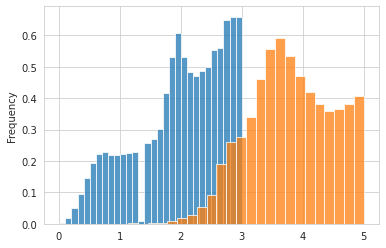

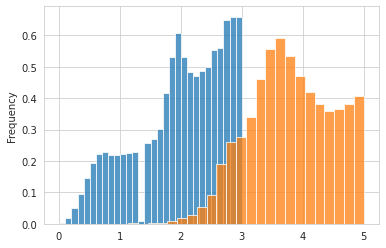

In [ ]:
#@title Contact data cleaning

df_case_rel = df_case
df_case_rel = df_case_rel[df_case_rel.Distance > 0]
df_case_rel = df_case_rel[~((df_case_rel.Distance > 1.3) & (df_case_rel.Distance < 1.4))]

import seaborn as sns
sns.set_style('whitegrid')
df_case_rel.Distance.plot.hist(bins=30, alpha=.75, density=True)
pd.read_csv('contacts_preprocessed.csv').Distance.plot.hist(bins=30, alpha=.75, density=True)
plt.show()

In [ ]:
#@title Result calculation

min_interactions = 10
contact_exponents = [3] #######

data = []
for (bfile, bm, bk, afile, am, ak), dfc in df_case_rel.groupby(['BFile', 'BModel', 'BKey', 'AFile', 'AModel', 'AKey']):
  bname, aname = bfile.replace('.pdb', ''), afile.replace('.pdb', '')
  dfc = dfc.copy()

  print(bname, bm, bk, '::', aname, am, ak)

  if len(dfc) < min_interactions:
    print(f'({len(dfc)} interaction{"" if len(dfc) == 1 else "s"})')
    continue

  dfc = dfc.groupby('AIndex').sum()####
  
  for exp in contact_exponents:
    weights = dfc.Distance ** -exp
    dfc[f'result{exp}'] = dfc.Prediction * weights

  for exp in contact_exponents:
    # results = dfc[f'result{exp}']
    results = dfc.sort_values(f'result{exp}', ascending=False).reset_index().loc[:10, f'result{exp}']
    cv = results.std() / results.mean()

    result = results.mean()
    result = np.log(result)

    data.append(dict(
        BFile=bfile,
        BModel=bm,
        BKey=bk,
        AFile=afile,
        AModel=am,
        AKey=ak,
        Exponent=exp,
        Result=result,
        CV=cv,
    ))

clear_output()
df_results = pd.DataFrame(data)
df_results = df_results.dropna()
df_results = df_results[df_results.Result > df_results.Result.quantile(.1)]
# df_results.Result -= df_results.Result.min()
# df_results.Result *= len(df_results) / df_results.Result.sum()
# df_results.Result -= df_results.Result.mean()
df_results = df_results.sort_values(['Exponent', 'Result'], ascending=False)
df_results = df_results.reset_index(drop=True)
df_results

,BFile,BModel,BKey,AFile,AModel,AKey,Exponent,Result,CV
0,5xj3.pdb,0,B,6yor.pdb,0,E,3,2.075411,3.300660
1,5yoy.pdb,0,R,6yor.pdb,0,A,3,0.561342,3.084651
2,6b3s.pdb,0,H,6yor.pdb,0,A,3,0.265275,3.280570
3,5b8c.pdb,0,E,6yor.pdb,0,A,3,0.218066,3.301731
4,5yoy.pdb,0,M,6yla.pdb,0,E,3,-0.075866,3.256946
...,...,...,...,...,...,...,...,...,...
3130,6bae.pdb,0,A,6yla.pdb,0,E,3,-8.476999,0.927589
3131,6b9z.pdb,0,A,6yla.pdb,0,E,3,-8.489930,0.940511
3132,4krp.pdb,0,C,6yla.pdb,0,A,3,-8.514496,0.846556
3133,4hkz.pdb,0,A,6w41.pdb,0,C,3,-8.516823,0.944481


,BFile,BModel,BKey,AFile,AModel,AKey,Exponent,Result,CV
0,5xj3.pdb,0,B,6yor.pdb,0,E,3,2.075411,3.300660
1,5yoy.pdb,0,R,6yor.pdb,0,A,3,0.561342,3.084651
2,6b3s.pdb,0,H,6yor.pdb,0,A,3,0.265275,3.280570
3,5b8c.pdb,0,E,6yor.pdb,0,A,3,0.218066,3.301731
4,5yoy.pdb,0,M,6yla.pdb,0,E,3,-0.075866,3.256946
...,...,...,...,...,...,...,...,...,...
3130,6bae.pdb,0,A,6yla.pdb,0,E,3,-8.476999,0.927589
3131,6b9z.pdb,0,A,6yla.pdb,0,E,3,-8.489930,0.940511
3132,4krp.pdb,0,C,6yla.pdb,0,A,3,-8.514496,0.846556
3133,4hkz.pdb,0,A,6w41.pdb,0,C,3,-8.516823,0.944481


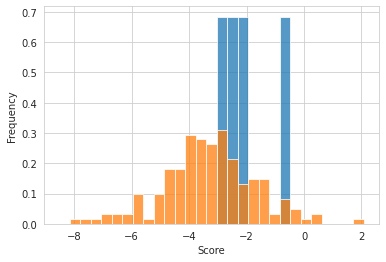

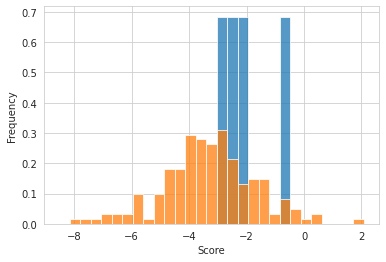

In [ ]:
#@title Result tabulation

def get_agg(df, side):
  if not len(df):
    return df
  df = df.groupby([f'{side}File', 'Exponent']).max()
  df = df.groupby(f'{side}File').max()
  df = df.drop(columns=['BModel', 'BKey', 'AModel', 'AKey'])
  df = df.sort_values('Result', ascending=False)
  return df

def get_thera(df, side):
  df = df.merge(df_thera_preprocessed.rename(columns=dict(File=f'{side}File', Model=f'{side}Model')))
  if not len(df):
    return df
  df = df.groupby(['Name', 'Exponent']).max()
  df = df.groupby('Name').max()
  df = df.drop(columns=['BModel', 'BKey', 'AModel', 'AKey', 'Heavy3', 'Light3'])
  df = df.sort_values('Result', ascending=False)
  return df


cmd('rm -rf results/ && mkdir results/')

df_results.round(5).to_csv(f'results/results_full.csv', index=False)

for side, other in ['AB', 'BA']:
  cmd(f'mkdir -p results/{side}_agg && mkdir -p results/{side}_thera')

  for other_file, dfr in df_results.groupby(f'{other}File'):
    other_name = other_file.replace('.pdb', '')

    dfr_agg = get_agg(dfr, side)
    if len(dfr_agg):
      dfr_agg.round(5).to_csv(f'results/{side}_agg/{side}_agg_{other_name}.csv', index=True)

    dfr_thera = get_thera(dfr, side)
    if len(dfr_thera):
      dfr_thera.round(5).to_csv(f'results/{side}_thera/{side}_thera_{other_name}.csv', index=True)

  bins = np.linspace(min(df_results.Result), max(df_results.Result), 30)

  df_results_agg = get_agg(df_results, side)
  if len(df_results_agg):
    df_results_agg.round(5).to_csv(f'results/{side}_agg.csv', index=True)

  df_results_thera = get_thera(df_results, side)
  if len(df_results_thera):
    df_results_thera.round(5).to_csv(f'results/{side}_thera.csv', index=True)

plt.xlabel('Score')
plt.ylabel('Density')
df_results[df_results.BFile.isin(ag_files)].groupby('BFile').max().Result.plot.hist(bins=bins, alpha=.75, density=True)
df_results.groupby('BFile').Result.max().plot.hist(bins=bins, alpha=.75, density=True)

cmd('rm -f results.tar.gz && tar -czvf results.tar.gz results/')

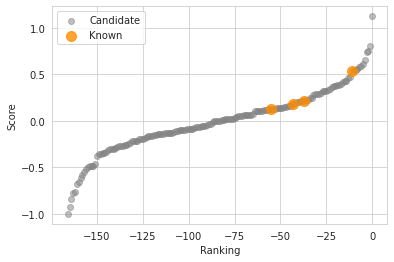

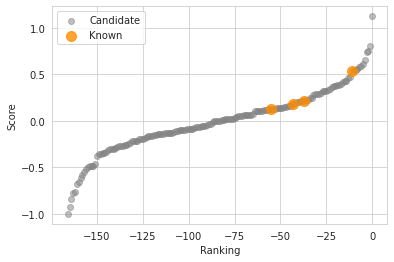

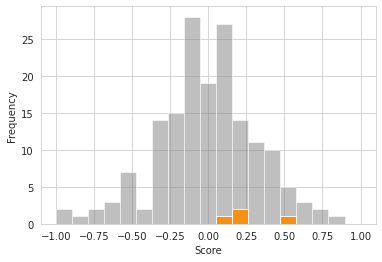

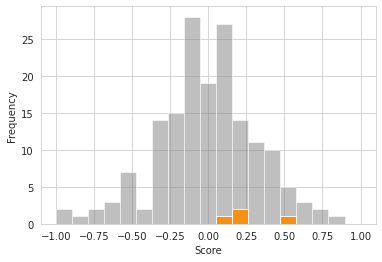

In [ ]:
#@title Relative score visualization

dfr = df_results.groupby(['BFile', 'Exponent']).max()
dfr = dfr.groupby('BFile').max().reset_index()
dfr = dfr.sort_values('Result', ascending=False)
dfr = dfr.reset_index(drop=True)
dfr = dfr.drop(columns=['BModel', 'BKey', 'AModel', 'AKey'])
dfr['P'] = dfr.Result - np.min(dfr.Result)
dfr.P /= dfr.P.sum()
dfr['Q'] = dfr.P * len(dfr)
dfr.Q = dfr.Q - dfr.Q.mean()

# dfr = dfr[dfr.Q >= 1]

ag_combined = True #@param {type:"boolean"}

dfrc = dfr[(dfr.BFile.isin(ag_files)) if ag_combined else (dfr.BFile == dfr.AFile)]
dfrx = dfr.drop(dfrc.index)

plt.xlabel('Ranking')
plt.ylabel('Score')
plt.scatter(-dfr.index, dfr.Q, label='Candidate', c='grey', alpha=.5)
plt.scatter(-dfrc.index, dfrc.Q, label='Known', c='darkorange', alpha=.8, marker='o', s=100)
plt.legend()
plt.show()

bins = np.linspace(-1, 1, 20)
dfr.Q.plot.hist(bins=bins, alpha=.5, color='grey')
dfrc.Q.plot.hist(bins=bins, alpha=.9, color='darkorange')
plt.xlabel('Score')
plt.show()

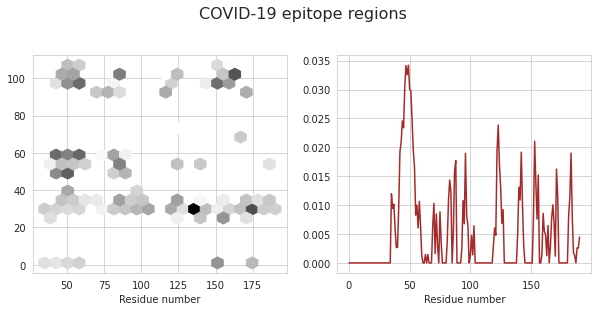

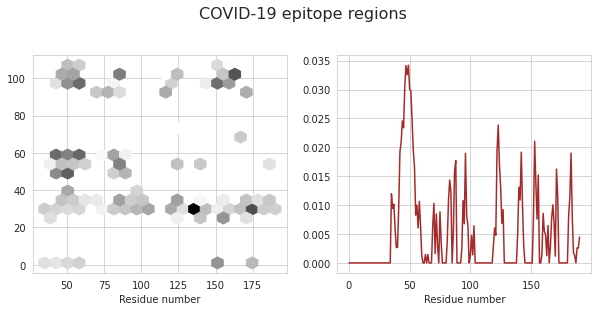

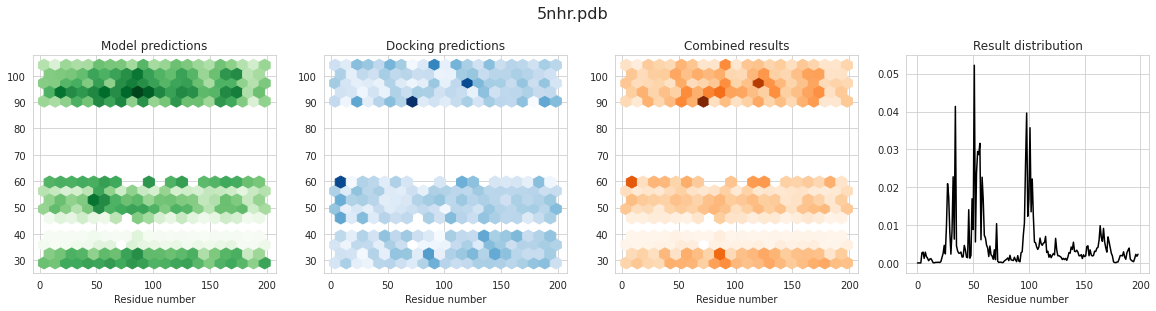

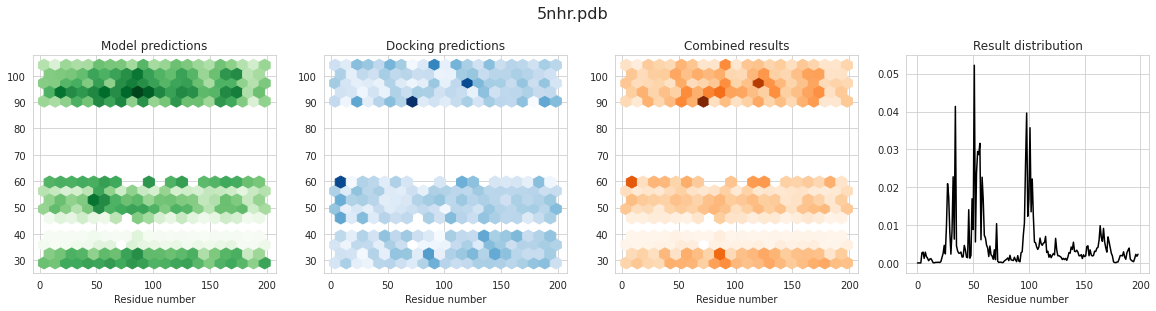

In [ ]:
#@title Antibody score visualization

bname = '5nhr' #@param {type: "string"}

# exp = max(contact_exponents)
exp = 1

bfile = f'{bname}.pdb'

dfx_true = pd.read_csv('contacts_preprocessed.csv')
dfx_true = dfx_true[dfx_true.File.isin(ag_files)]

dfx_true = dfx_true[dfx_true.AIndex <= 200] ##

dfx_true['Weight'] = dfx_true.Distance ** -exp

dfxtg = dfx_true.groupby('AIndex').sum()

fig, (ax, bx) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('COVID-19 epitope regions', y=1.05, fontsize=16)

ax.set_xlabel('Residue number')
ax.hexbin(dfx_true.AIndex, dfx_true.BIndex, dfx_true.Weight, gridsize=20, cmap=plt.cm.Greys)

y = np.zeros(max(dfxtg.index) + 1)
y[dfxtg.index] = dfxtg.Weight
y /= y.sum()
bx.set_xlabel('Residue number')
bx.plot(y, c='brown')

plt.show()

# for bkey in df_case_rel[df_case_rel.BFile == bfile].BKey.unique():

if np.any(df_case_rel.BFile == bfile):

  # dfxa = df_case[(df_case.BFile == bfile) & (df_case.BKey == bkey)]
  dfxa = df_case[df_case.BFile == bfile]

  # dfx = df_case_rel[(df_case_rel.BFile == bfile) & (df_case_rel.BKey == bkey)]
  dfx = df_case_rel[df_case_rel.BFile == bfile]
  dfx = dfx.copy()
  dfx['Weight'] = dfx.Distance ** -exp
  dfx['Result'] = dfx.Prediction * dfx.Weight

  fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(20, 4))
  # fig.suptitle(f'{bfile} chain {bkey}', y=1.05, fontsize=16)
  fig.suptitle(bfile, y=1.05, fontsize=16)

  ax.set_title('Model predictions')
  ax.set_xlabel('Residue number')
  ax.hexbin(dfx.AIndex, dfx.BIndex, dfx.Prediction, gridsize=20, cmap=plt.cm.Greens)

  bx.set_title('Docking predictions')
  bx.set_xlabel('Residue number')
  bx.hexbin(dfx.AIndex, dfx.BIndex, dfx.Distance ** -1, gridsize=20, cmap=plt.cm.Blues)

  cx.set_title('Combined results')
  cx.set_xlabel('Residue number')
  cx.hexbin(dfx.AIndex, dfx.BIndex, dfx.Result, gridsize=20, cmap=plt.cm.Oranges)

  dfxg = dfx.groupby('AIndex').sum()

  y = np.zeros(max(dfxg.index) + 1)
  y[dfxg.index] = dfxg.Result
  y /= y.sum()

  dx.set_title('Result distribution')
  dx.set_xlabel('Residue number')
  dx.plot(y, c='black')
  plt.show()

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

df_results[df_results.Result > 0].Result.plot.hist(bins=20, label='Individual', alpha=.75, density=True)
df_results[df_results.Result > 0].groupby(['BFile', 'Exponent']).mean().groupby('BFile').mean().Result.plot.hist(bins=20, label='Aggregated', alpha=.5, density=True)
plt.xlabel('Score')
plt.ylabel('Probability')
plt.legend()
plt.show()

dfr = df_results[df_results.Result > 0].groupby(['BFile', 'Exponent']).mean().groupby('BFile').mean()

dfr[dfr.Result >= dfr.Result.quantile(.95)].drop(columns=['BModel', 'AModel']).sort_values('Result', ascending=False)

#### Antigen invariant

In [ ]:
#@title Thera feature assembly

ag_pdb = '6yor' #@param {type:"string"}
# ag_key = 'C' #@param {type:"string"}
# ag_model = 0 #@param {type:"integer"}

ag_file = f'{ag_pdb}.pdb'

n_antibodies = 0 #@param {type:"slider", min:0, max:20, step:1}

ab_files = [ag_file] + extra_files + thera_files
if n_antibodies:
  ab_files = np.random.choice(ab_files, n_antibodies, replace=False)

# dfs = df_docked_secondary
# dfs_arel = dfs[(dfs.File == ag_file) & (dfs.Model == ag_model)].set_index('Key')
# print(sorted(dfs_arel.index))
# assert ag_key in dfs_arel.index

dfd = df_docked_preprocessed
# display(dfd[dfd.File == ag_file])##
# dfd = dfd[(dfd.File == ag_file) & (dfd.Model == ag_model) & (dfd.AKey == ag_key)]
dfd = dfd[dfd.File == ag_file]
assert len(dfd)

df_case = assemble(ab_files, (ag_file,))
# ###
# df_case = df_case[(df_case.AModel == ag_model) & (df_case.AKey == ag_key)]
df_case.to_csv(f'features_ag_{ag_pdb}.csv', index=False)
clear_output()
df_case

NameError: ignored

NameError: ignored

In [ ]:
#@title Model evaluation

df_case['score'] = predict_all(df_case).T[0]
clear_output()

data = []
for (file, mid, bk, ak), dfc in df_case.groupby(['BFile', 'BModel', 'BKey', 'AKey']):

  # fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(16, 3))
  # fig.suptitle(f'{file} [{mid}] ({bk} x {ak})', fontsize=16)
  
  # hex_gridsize = 15
  # ax.set_xlabel('Antigen Sequence')
  # ax.hexbin(dfc.AIndex, dfc.BIndex, dfc.score, gridsize=hex_gridsize, cmap=plt.cm.BuGn)

  # bx.set_xlabel('Antibody Sequence')
  # bx.set_ylabel('Score')
  # # dfg.true.plot(ax=cx)
  # x = np.zeros(max(dfc.BIndex) + 1)
  # dfbg = dfc.groupby('BIndex').mean().sort_index().score
  # x[dfbg.index] = dfbg
  # bx.plot(x)

  # cx.set_xlabel('Antigen Sequence')
  # cx.set_ylabel('Score')
  # # dfg.true.plot(ax=cx)
  # dfc.groupby('AIndex').mean().sort_index().score.plot(ax=cx)

  # dx.set_xlabel('Score')
  # # dx.set_ylim(0, np.max(dfg[['true', 'false']].values))
  # dx.set_ylim(0, len(dfg) / 10)
  # # dfg.true.hist(ax=dx, bins=10, density=True)
  # # dfg.false.hist(ax=dx, bins=10, density=True)
  # dfg.score.hist(ax=dx, bins=10)

  # plt.show()

  data.append(dict(
      File=file,
      Model=mid,
      BKey=bk,
      AKey=ak,
      Score=dfc.score.mean(),
      Std=dfc.score.std(),
  ))

df_scores = pd.DataFrame(data)
df_scores = df_scores.sort_values('Score', ascending=False)
df_scores = df_scores.reset_index(drop=True)
df_scores.round(5).to_csv(f'scores_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
display(df_scores)

df_scores_agg = df_scores.groupby(['File', 'Model', 'AKey']).mean().sort_values('Score', ascending=False).reset_index()
df_scores_agg.round(5).to_csv(f'scores_agg_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
display(df_scores_agg)

df_case.groupby('AIndex').mean().sort_index().reset_index(drop=True)[['score']].rolling(contact_buffer, center=True).mean().reset_index(drop=True).plot(legend=False)
plt.show()

df_thera_preprocessed = pd.read_csv('thera_preprocessed.csv')

df = df_scores_agg.merge(df_thera_preprocessed, on=['File'])
df = df.drop_duplicates(['File', 'Model', 'Name'])
df = df.drop(columns=['Heavy', 'Light', 'Heavy2', 'Light2', 'Heavy3', 'Light3'])
df.round(5).to_csv(f'scores_full_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
df

In [ ]:
#@title Contact point preloading

df_contacts_parts = []
for (bfile, bm, afile, am, ak), dfc_g in df_case.groupby(['BFile', 'BModel', 'AFile', 'AModel', 'AKey']):
  bname = bfile.replace('.pdb', '')
  aname = afile.replace('.pdb', '')

  hkeys = dfc_g[dfc_g.Type == 'H'].BKey.unique()
  lkeys = dfc_g[dfc_g.Type == 'L'].BKey.unique()

  for hk in hkeys:
    for lk in lkeys:
      contact_path = f'outputs/Contacts/{bname}_{bm}_{aname}_{am}_{hk}{lk}{ak}_Docked_Hex.csv'
      exists = os.path.exists(contact_path)
      print('+' if exists else '-', bname, bm, aname, am, [hk, lk, ak])
      if exists:
        dfx = pd.read_csv(contact_path)
        dfx = dfx.drop(columns='Unnamed: 0', errors='ignore')
        df_contacts_parts.append(dfx)

df_contacts = pd.concat(df_contacts_parts)
del df_contacts_parts
clear_output()
df_contacts

In [ ]:
#@title Epitope filtering

epitope_padding = 5

dfc = df_contacts[(df_contacts.BFile == df_contacts.AFile) & (df_contacts.BModel == df_contacts.AModel)]
dfc_ai = np.array(sorted(set(n for i in dfc.AIndex.unique() for n in range(i - epitope_padding, i + epitope_padding + 1))))

df_contacts = df_contacts[df_contacts.AIndex.isin(dfc_ai)]
df_contacts

In [ ]:
#@title Contact-weighted analysis

min_interactions = 10
# contact_exponents = range(2, 4)
contact_exponents = [2]

data = []
for (bfile, bm, afile, am, bk, ak), dfc in df_case.groupby(['BFile', 'BModel', 'AFile', 'AModel', 'BKey', 'AKey']):
      dfc = dfc.copy()
      # dfc = dfc.merge(df_adj.rename(columns={'File': 'BFile', 'Model': 'BModel'}), on=['BFile', 'BModel', 'BKey', 'AKey'])

      print(bfile.replace('.pdb', ''), bm, bk, '::', afile.replace('.pdb', ''), am, ak)

      dfx = df_contacts
      dfx = dfx[(dfx.BFile == bfile) & (dfx.BModel == bm) & (dfx.AFile == afile) & (dfx.AModel == am) & (dfx.AKey == ak)]
      dfx = dfx.copy()
      
      # for ai, dfc_g in dfc.groupby('AIndex'):
      #   dfc.loc[dfc_g.index, 'weight'] = len(dfx[dfx.AIndex == ai])

      # for ai, dfc_g in dfc.groupby('AIndex'):
      #   # dfc.loc[dfc_g.index, 'weight'] = len(dfx[dfx.AIndex == ai])
      #   dfc.loc[dfc_g.index, 'weight'] = (1 / dfx[dfx.AIndex == ai].Distance).mean()

      for exp in contact_exponents:
        dfx.loc[:, f'weight{exp}'] = 1 / dfx.Distance ** exp

      dfc = dfc.merge(dfx, on=['BIndex', 'AIndex']).groupby(['BIndex', 'AIndex']).sum().reset_index()

      if len(dfc) < min_interactions:
        print(f'({len(dfc)} interaction{"" if len(dfc) == 1 else "s"})')
        continue

      # scores = dfc.score / dfc.MScore #####
      scores = dfc.score
      for exp in contact_exponents:
        dfc[f'result{exp}'] = scores / scores.sum() * dfc[f'weight{exp}'] / dfc[f'weight{exp}'].sum() * 1e8

      # visual_results = dfc.result3

      # fig, (ax, bx) = plt.subplots(1, 2, figsize=(10, 3))

      # ax.hexbin(dfc.AIndex, dfc.BIndex, visual_results, gridsize=30, cmap=plt.cm.BuGn)

      # dfg = dfc.groupby('AIndex').mean().sort_index()
      # dfgr = dfg.rolling(contact_buffer, center=True).mean()

      # dfgr[[c for c in dfgr.columns if c.startswith('result')]].plot(ax=bx, label='Result', legend=False, c='black')
      # fig.suptitle(f'{bfile} {bm} {hk}{lk}{ak}')
      # plt.show()

      for exp in contact_exponents:
        results = dfc[f'result{exp}']
        data.append(dict(
            File=bfile,
            Model=bm,
            BKey=bk,
            AKey=ak,
            Exponent=exp,
            Result=results.mean(),
            Std=results.std(),
        ))

clear_output()
df_results = pd.DataFrame(data)
df_results = df_results[df_results.Result > 0]
df_results.insert(5, 'LogResult', np.log(df_results.Result))
df_results.insert(6, 'CV', df_results.Std / df_results.Result)
df_results = df_results.sort_values(['Exponent', 'LogResult'], ascending=False)
df_results = df_results.reset_index(drop=True)
df_results.round(5).to_csv(f'results_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
display(df_results)

df_results = df_results.drop(columns=['Result', 'Std'])

df_results_agg = df_results.groupby(['File', 'Model', 'AKey', 'Exponent']).mean().sort_values(['Exponent', 'LogResult'], ascending=False)
df_results_agg.round(5).to_csv(f'results_agg_{ag_pdb}_{ag_model}_{ag_key}.csv', index=True)
display(df_results_agg)

df_results_thera = df_results.merge(df_thera_preprocessed).groupby('Name').mean().drop(columns=['Model', 'Exponent', 'Heavy3', 'Light3']).sort_values('LogResult', ascending=False)
df_results_thera.round(5).to_csv(f'results_thera_{ag_pdb}_{ag_model}_{ag_key}.csv', index=True)
display(df_results_thera)

!mkdir -p results/
!cp results_{ag_pdb}_{ag_model}_{ag_key}.csv results/

for exp, dfr in df_results.groupby('Exponent'):
  dfr[['LogResult']].plot.hist(bins=20, legend=False, color='black')
  plt.title(exp)
  plt.show()

In [ ]:
#@title Result combination

dfd = pd.read_csv('docked_preprocessed.csv')

df_parts = []
for csv_file in os.listdir('results/'):
  path = f'results/{csv_file}'
  if os.path.isfile(path):
    df_part = pd.read_csv(path)
    df_parts.append(df_part)

df = pd.concat(df_parts)
df = df[df.Exponent >= 2] ####
df = df[df.Result > 0]
df.round(5).to_csv('combined_full.csv', index=False)
display(df)

df = df.groupby(['File']).mean()
df = df.drop(columns=['Model', 'Exponent', 'Result', 'Std'])
df = df.sort_values('LogResult', ascending=False)
df.round(5).to_csv('combined_agg.csv', index=True)
display(df)

df_thera = df.reset_index().merge(df_thera_preprocessed).groupby(['File', 'Name']).mean()[['LogResult', 'CV']].sort_values('LogResult', ascending=False)
df_thera.round(5).to_csv(f'combined_thera.csv', index=True)
display(df_thera)

df_thera_agg = df_thera.groupby('Name').mean().sort_values('LogResult', ascending=False)
df_thera_agg.round(5).to_csv(f'combined_thera_agg.csv', index=True)
display(df_thera_agg)

In [ ]:
#@title Contact visualization

dfx = df_contacts[df_contacts.BFile.isin(extra_files)]
dfx = dfx.copy()

for k in contact_exponents:
  colname = f'Exp {k}'
  dfx[colname] = 1 / dfx.Distance ** k
  dfx[colname] /= dfx[colname].sum()

  dfx.groupby('AIndex').mean().sort_index()[[c for c in dfx.columns if c.startswith('Exp')]].plot(legend=False, c='black')
  plt.title(colname)
  plt.show()

##### Scoring bias analysis

In [ ]:
#@title Thera bias calculation

n_antibodies = 30 #@param {"type":"slider", "min":1, "max":30}
min_priority = 4 #@param {"type":"slider", "min":1, "max":4}

bias_bfiles = list(dft[dft.Priority >= min_priority].File.unique())
bias_bfiles = bias_bfiles[::len(bias_bfiles) // n_antibodies]

dfd = pd.read_csv('docked_preprocessed.csv')
df_bias_entries = pd.concat([dfd[dfd.File.isin(ab_extras)][['File', 'Model', 'AKey']], dft[dft.Priority >= min_priority]])

data = []
for i, row in df_bias_entries.iterrows():
  clear_output()
  dff = assemble(row.File, row.Model, row.AKey, bias_bfiles, 5)

  if not len(dff):
    print('Skipping')
    continue

  scores = model.predict(encode_features(dff))

  data.append({
      'File': row.File,
      'Model': row.Model,
      'AKey': row.AKey,
      'Score': scores.mean(),
      'Std': scores.std(),
  })

clear_output()
df_bias = pd.DataFrame(data)
df_bias = df_bias.round(5)
df_bias = df_bias.sort_values('Score', ascending=False)
df_bias.to_csv(f'bias_thera_{min_priority}.csv', index=False)
df_bias

In [ ]:
#@title Relative score calculation

df_bias = pd.read_csv(f'bias_thera_{min_priority}.csv')

df_adj = df_scores.merge(df_bias.drop(columns='AKey').rename(columns={'Score': 'MScore', 'Std': 'MStd'}), on=['File', 'Model'])

df_adj['RelScore'] = df_adj.Score / df_adj.MScore
df_adj['RelStd'] = df_adj.Std / df_adj.MStd
df_adj = df_adj.sort_values('RelScore', ascending=False).reset_index(drop=True)
df_adj.round(5).to_csv(f'scores_relative_full_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
display(df_adj)

df_adj_concise = df_adj[['File', 'RelScore']]
df_adj_concise.to_csv(f'scores_relative_concise_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
display(df_adj_concise)

df_adj_agg = df_adj.groupby('File').mean().drop(columns=['Model'])
df_adj_agg = df_adj_agg.reset_index()
df_adj_agg = df_adj_agg.sort_values('RelScore', ascending=False)
df_adj_agg.round(5).to_csv(f'scores_relative_agg_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
display(df_adj_agg)

df = df_adj.merge(df_thera_preprocessed, on='File')
df = df.drop(columns=['Heavy', 'Light', 'Heavy2', 'Light2', 'Heavy3', 'Light3'])
df = df.groupby(['Name']).mean()
df = df.sort_values('RelScore', ascending=False).reset_index()
df = df.drop(columns=['Model'])

# df_adj.to_csv(f'scores_relative_full_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
# df_adj[['Name', 'RelScore']].to_csv(f'scores_relative_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
df.round(5).to_csv(f'scores_relative_{ag_pdb}_{ag_model}_{ag_key}.csv', index=False)
df